In [1]:
#Importing important header files

import math                                #For mathematical functions such as squareroot
import tensorflow as tf                    #For building the learning model
import numpy as np                         #For array operations and manipulation
import pylab as plt                        #For plotting relevant data
from sklearn import model_selection        #For shuffling and spliting of input data
import time as t                           #For finding run time of tensorflow session

In [18]:
#Initialization of required variables and parameters

NUM_FEATURES = 21
NUM_CLASSES = 3
NUM_HIDDEN = 10

learning_rate = 0.01
epochs = 1000
batch_size = 32

seed = 10
np.random.seed(seed)

In [3]:
#Function that traverses throught every row of the matrix, and return a one hot matrix

def one_hot_matrix(input_data):
    hot_mat = np.zeros((input_data.shape[0], NUM_CLASSES))
    hot_mat[np.arange(input_data.shape[0]), input_data - 1] = 1  # one hot matrix
    return hot_mat

In [5]:
def init_bias(n=1):
    return tf.Variable(np.zeros([n]), dtype=tf.float32, name='biases')

In [4]:
def init_weights(n_in=1, n_out=1):
    return tf.Variable(tf.truncated_normal([n_in, n_out], stddev=1.0 / math.sqrt(float(n_in))), dtype=tf.float32,
                       name='weights')

In [6]:
def scale(X, X_min, X_max):
    return (X - X_min) / (X_max - X_min)

In [7]:
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter=',')

# Split dataset into train / test
trainX, testX, trainY, testY = model_selection.train_test_split(
    train_input[1:, :21], train_input[1:, -1].astype(int), test_size=0.3, shuffle=True)

In [8]:
#Scaling of training and testing input data

trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))
testX = scale(testX, np.min(testX, axis=0), np.max(testX, axis=0))
total_count = len(trainX)

print("TRAINING INPUT") 
print(trainX)
print("\nNumber of rows : %d" %(total_count))

TRAINING INPUT
[[0.59259259 0.         0.         ... 0.61320755 0.00371747 1.        ]
 [0.57407407 0.         0.03354298 ... 0.62264151 0.01115242 1.        ]
 [0.46296296 0.33333333 0.06289308 ... 0.59433962 0.14126394 0.        ]
 ...
 [0.40740741 0.61111111 0.0230608  ... 0.58490566 0.0669145  0.5       ]
 [0.66666667 0.77777778 0.12578616 ... 0.93396226 0.08178439 1.        ]
 [0.16666667 0.11111111 0.         ... 0.31132075 0.12267658 0.        ]]

Number of rows : 1488


In [9]:
#Initialization of training and testing output data

trainY = one_hot_matrix(trainY)
testY = one_hot_matrix(testY)

print("TRAINING OUTPUT") 
print(trainY)
print("\nNumber of rows : %d" %(total_count))

TRAINING OUTPUT
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

Number of rows : 1488


In [10]:
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
d = tf.placeholder(tf.float32, [None, NUM_CLASSES])
weight_decay_param = tf.placeholder(tf.float32)

In [11]:
# Define variables:
V = init_weights(NUM_HIDDEN, NUM_CLASSES)
c = init_bias(NUM_CLASSES)
W = init_weights(NUM_FEATURES, NUM_HIDDEN)
b = init_bias(NUM_HIDDEN)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
#Define model
z = tf.matmul(x, W) + b
h = tf.nn.relu(z)
u = tf.matmul(h, V) + c
p = tf.exp(u) / tf.reduce_sum(tf.exp(u), axis=1, keepdims=True)
y = tf.argmax(p, axis=1)

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=d, logits=u)
loss = tf.reduce_mean(cross_entropy) + weight_decay_param*(tf.reduce_mean(tf.math.square(V))+tf.reduce_mean(tf.math.square(W)))

In [14]:
# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

In [15]:
correct_prediction = tf.cast(tf.equal(tf.argmax(u, 1), tf.argmax(d, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [26]:
#Run tensorflow session

weight_acc = []
weight_time = []

for n in range(0,-13,-3):

    weight_decay = 0.0;
    if(n!=0):
        weight_decay = pow(10,n)
    print("Weight Decay Parameter %g" %weight_decay)
    
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        train_acc = []
        start_time = t.time()

        for i in range(epochs):

            idx = np.arange(total_count)
            np.random.shuffle(idx)
            trainX, trainY = trainX[idx], trainY[idx]

            fold_acc = []

            for k in range(5):
                start_index = k * (total_count // 5)
                stop_index = (k + 1) * (total_count // 5)

                train_x = np.concatenate((trainX[0:start_index],trainX[stop_index:total_count]))
                train_y = np.concatenate((trainY[0:start_index],trainY[stop_index:total_count]))
                test_x = trainX[start_index:stop_index]
                test_y = trainY[start_index:stop_index] 

                fold_count = len(train_x)

                for j in range(batch_size, fold_count, batch_size):
                    batch_x = train_x[j - batch_size:j]
                    batch_y = train_y[j - batch_size:j]

                    train_op.run(feed_dict={x: batch_x, d: batch_y, weight_decay_param: weight_decay})

                fold_acc.append(accuracy.eval(feed_dict={x: test_x, d: test_y, weight_decay_param: weight_decay}))

            train_acc.append(sum(fold_acc) / len(fold_acc))
            if i % 100 == 0:
                print('iteration %5d: | train accuracy : %10g ' % (i, train_acc[i]))

        stop_time = t.time()
        weight_acc.append(train_acc)
        weight_time.append(stop_time - start_time)
        
        print('\ntotal Time %d: ' % (stop_time - start_time))

Weight Decay Parameter 0
iteration     0: | train accuracy :   0.778451 
iteration   100: | train accuracy :   0.899663 
iteration   200: | train accuracy :   0.904377 
iteration   300: | train accuracy :   0.908418 
iteration   400: | train accuracy :   0.910438 
iteration   500: | train accuracy :   0.913805 
iteration   600: | train accuracy :   0.912458 
iteration   700: | train accuracy :   0.917172 
iteration   800: | train accuracy :   0.918519 
iteration   900: | train accuracy :   0.919865 

total Time 207: 
Weight Decay Parameter 0.001
iteration     0: | train accuracy :   0.777778 
iteration   100: | train accuracy :   0.900337 
iteration   200: | train accuracy :   0.906397 
iteration   300: | train accuracy :   0.908418 
iteration   400: | train accuracy :   0.913805 
iteration   500: | train accuracy :   0.915825 
iteration   600: | train accuracy :   0.919192 
iteration   700: | train accuracy :   0.922559 
iteration   800: | train accuracy :   0.921212 
iteration   900:

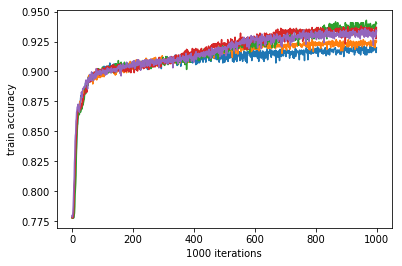

In [28]:
# plot learning curves

plt.figure(1)
for i in range(5):
    plt.plot(range(epochs), weight_acc[i])
plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('train accuracy')
plt.show()